**Tecnológico de Monterrey**

**Maestría en Inteligencia Artificial Aplicada**

**ASIGNATURA: Proyecto Integrador**

**PROFESOR TITULAR: Dra. Grettel Barceló Alonso**

**ACTIVIDAD:Avance 2. Ingeniería de Características**

---
**EQUIPO 3**

*   Rayan Bahrein García Fabián - A01204055
*   Brandon Alexis del Ángel Gómez - A01795429
*   Fernando Jiménez Pereyra - A01734609

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
DIR = "/content/drive/MyDrive/Poyecto/Datos"
os.chdir(DIR)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from datetime import datetime
from scipy.stats import zscore

In [ ]:
empleados = pd.read_csv('empleados_final.csv')
proyectos = pd.read_csv('proyectos_final.csv')
asignaciones = pd.read_csv('asignaciones_final.csv')

# Estructura de los datos

Una vez que cargamos los datos verificamos la forma y columnas.

In [ ]:
print("Estructura inicial de los datos:")
print("Empleados:", empleados.shape)
print("Proyectos:", proyectos.shape)
print("Asignaciones:", asignaciones.shape)

Estructura inicial de los datos:
Empleados: (3000, 5)
Proyectos: (3000, 6)
Asignaciones: (31864, 5)


In [ ]:
empleados.head()

,employee_id,role,experience_years,skills,availability
0,3427,Production Technician I,5,"['Mantenimiento', 'Control de Calidad', 'Análi...",Disponible
1,3428,Production Technician I,1,"['Calibración', 'Mantenimiento', 'Trabajo en E...",Disponible
2,3429,Area Sales Manager,6,"['ERP', 'Java', 'Comunicación']",Disponible
3,3430,Area Sales Manager,3,"['Power BI', 'SQL', 'Análisis de Mercado']",Disponible
4,3431,Area Sales Manager,5,"['Rutas de Distribución', 'Sistemas Operativos...",Disponible


# Transformación y gneración de características

## Generación de nuevas características


1.   Duración del proyecto en días
2.   Número de habilidades requeridas por proyecto
3.   Número de habilidades por empleado
4.   Generar variable binaria - ¿empleado disponible?
5.   Creamos variable de "match skills" entre empleado y proyecto


Justificación:

Estas variables aportan conocimiento contextual importante como: 1) duración del proyecto para estimar carga de trabajo y disponibilidad requerida, 2) número de habilidades para capturar complejidad del perfil y 3) la coincidencia entre habilidades y requisitos para evaluar afinidad técnica relevante para el modelo.



In [ ]:
# Aseguramos que las fechas estén en formato datetime
proyectos['start_date'] = pd.to_datetime(proyectos['start_date'], errors='coerce')
proyectos['end_date'] = pd.to_datetime(proyectos['end_date'], errors='coerce')

# 1. Duración del proyecto en días
proyectos['project_duration_days'] = (proyectos['end_date'] - proyectos['start_date']).dt.days

# 2. Número de habilidades requeridas por proyecto
proyectos['n_required_skills'] = proyectos['required_skills'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# 3. Número de habilidades por empleado
empleados['n_skills'] = empleados['skills'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# 4. Generar variable binaria: ¿empleado disponible?
empleados['is_available'] = empleados['availability'].apply(lambda x: 1 if x == "Disponible" else 0)

# 5. Crear variable de "match de skills" entre empleado y proyecto
# Supone que luego unimos empleados con proyectos (por ahora solo función auxiliar)
def skill_match(emp_skills, proj_skills):
    emp_skills = set(emp_skills)
    proj_skills = set(proj_skills)
    return len(emp_skills.intersection(proj_skills)) / len(proj_skills) if proj_skills else 0


proyectos.head(3)
empleados.head(3)


,employee_id,role,experience_years,skills,availability,n_skills,is_available
0,3427,Production Technician I,5,"['Mantenimiento', 'Control de Calidad', 'Análi...",Disponible,3,1
1,3428,Production Technician I,1,"['Calibración', 'Mantenimiento', 'Trabajo en E...",Disponible,3,1
2,3429,Area Sales Manager,6,"['ERP', 'Java', 'Comunicación']",Disponible,3,1


## Discretización o binning

Realizamos la discretización de experiencia de empleados en 4 niveles (cuantiles).

El binning transforma una variable continua en categorías ordinales interpretables. Esto nos puede ser útil para modelos como decission trees o XGBoost, y facilita la segmentación del talento por niveles de experiencia.

In [ ]:
# Discretizar experiencia de empleados en 4 niveles (cuantiles)
empleados['experience_bin'] = pd.qcut(empleados['experience_years'], q=4, labels=["Baja", "Media", "Alta", "Muy Alta"])


## Codificación de variables categóricas

Codificamos `complexity` del proyecto como ordinal (de Baja a Alta) y One-hot encoding para `category` del proyecto.

En este caso la justificación de la codificación ordinal es para respetar el orden lógico en la variable `complexity`. En el caso de One-hot encodign es para evitar introdcir relaciones artificiales entre categorías nominales no ordenadas.





In [ ]:
from sklearn.preprocessing import OneHotEncoder
# Codificamos 'complexity' del proyecto como ordinal (de Baja a Alta)
complexity_map = {"Baja": 1, "Media": 2, "Alta": 3}
proyectos['complexity_encoded'] = proyectos['complexity'].map(complexity_map)

# One-hot encoding para 'category' del proyecto
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
project_categories = ohe.fit_transform(proyectos[['category']])
project_categories_df = pd.DataFrame(project_categories, columns=ohe.get_feature_names_out(['category']))
proyectos = pd.concat([proyectos.reset_index(drop=True), project_categories_df], axis=1)


## Escalamiento

Estandarizamos la duración del proyecto y número de habilidades requeridas.

La estandarización es útil para algoritmos sensibles a escala como lo pueden ser (regresiones, SVM o redes neuronales). Por su parte Min-max nos prmite comprimir rangos a [o,1] sin perder proporcionalidad relativa.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

# Estandarizar duración del proyecto y número de habilidades requeridas
proyectos[['project_duration_scaled']] = scaler_std.fit_transform(proyectos[['project_duration_days']])
proyectos[['n_required_skills_scaled']] = scaler_minmax.fit_transform(proyectos[['n_required_skills']])


## Transformaciones no lineales

Aplicamos Yeo-Johnson a experiencia si es necesario corregir sesgo. Esta transformación es útil cuando la variable tiene una distribución sesgada, ayudando a cumplir supuestos de normalidad o acelerar su convergencia en alugunos modelos.

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Aplicar Yeo-Johnson a experiencia corregir sesgo
pt = PowerTransformer(method='yeo-johnson')
empleados['experience_transformed'] = pt.fit_transform(empleados[['experience_years']])

Comentarios:

En el dataset 'empleados', las columnas `ExitDate` y `TerminationDescription` tienen valores faltantes, lo cual es de esperar ya que la base de datos contiene información de colaboradores activos e inactivos.

Los data sets de 'proyectos' y 'asignaciones' no presentan valores nulos en variables críticas.

# Selección y extracción de características

## Umbral de varianza (eliminar variables con baja variablilidad)

Las variables con muy poca variación entre muestras no suelen aportar información útil a los modelos y pueden incluso añadir ruido o sobreajuste. En esta sección aplicamos un umbral mínimo determinado en 0.01

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Supongamos que estamos trabajando con variables numéricas del dataset de proyectos
features_numericas = proyectos[[
    'project_duration_scaled',
    'n_required_skills_scaled'
]]

# Aplicar un umbral mínimo de varianza (por ejemplo, 0.01)
selector_var = VarianceThreshold(threshold=0.01)
X_var = selector_var.fit_transform(features_numericas)

# Variables retenidas
variables_ret = features_numericas.columns[selector_var.get_support()]
print("Variables retenidas por varianza:", list(variables_ret))

Variables retenidas por varianza: ['project_duration_scaled', 'n_required_skills_scaled']


## Correlación

Análisis de correlación para identificar multicolinealidad. Altas correlaciones entre variables pueden indicar redundancia. En este caso podríamos eliminar una de las variables altamente correlacionadas para evitar multicolinealidad.

En este caso identificamos que la duración del proyecto no tiene correlación con el número de habilidades requeridas.

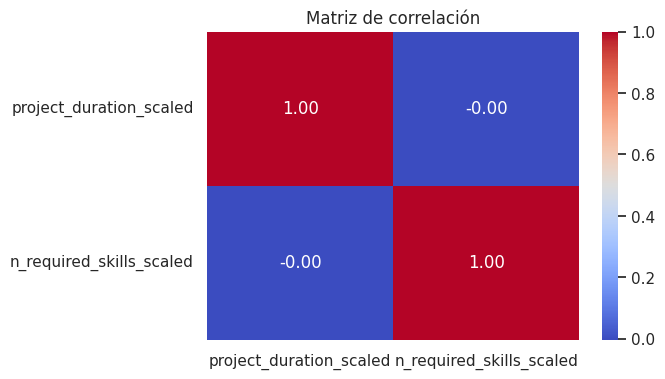

In [ ]:
# Calcular matriz de correlación de las variables numéricas
corr = features_numericas.corr()

# Visualizar como mapa de calor
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


## Chi-cuadrada

Para variables categóricas vs objetivo discreto. La prueba chi-cuadrada evalúa si existe relación entre dos variables categóricas. Si p < 0.05, la variable categórica es estadísticamente relevante.

En el ejemplo que realizamos determinamos que nuestra variable no es estadísticamente relevante.

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

# Ejemplo artificial: clasificamos los scores como alto/bajo
asignaciones['score_label'] = (asignaciones['contribution_score'] > 50).astype(int)

# Convertimos 'assigned_role' a valores numéricos
le = LabelEncoder()
X_cat = le.fit_transform(asignaciones['assigned_role'])

# Aplicamos chi-cuadrado
chi2_score, p_values = chi2(X_cat.reshape(-1, 1), asignaciones['score_label'])

print("Chi-cuadrado:", chi2_score[0])
print("p-value:", p_values[0])

Chi-cuadrado: 0.2411630104598008
p-value: 0.623367386399527


## PCA

El análisis de componente principales permite transformar variables correlacionadas en componente ortogonales que capturan la varianza. Esto es útil para reducir dimensionalidad y eliminar colinealidad. Es importante tener en mente que esto puede llegar a sacrificar interpretabilidad directa.

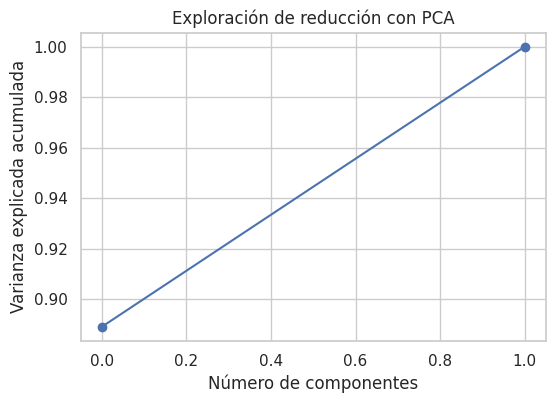

In [ ]:
from sklearn.decomposition import PCA

# Usamos las variables numéricas escaladas
X_pca = features_numericas.copy()

# PCA sin reducción forzada, solo para explorar varianza explicada
pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca)

# Graficar varianza explicada acumulada
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.title("Exploración de reducción con PCA")
plt.grid(True)
plt.show()


## Tabla resumen de nuevas características y transformadas

In [ ]:
resumen_features = pd.DataFrame([
    {"Variable": "project_duration_days", "Tipo": "Generada", "Origen": "proyectos", "Descripción": "Duración del proyecto en días"},
    {"Variable": "n_required_skills", "Tipo": "Generada", "Origen": "proyectos", "Descripción": "Número de habilidades requeridas"},
    {"Variable": "n_skills", "Tipo": "Generada", "Origen": "empleados", "Descripción": "Número de habilidades del recurso"},
    {"Variable": "is_available", "Tipo": "Generada", "Origen": "empleados", "Descripción": "Disponibilidad del empleado (binaria)"},
    {"Variable": "experience_bin", "Tipo": "Discretizada", "Origen": "empleados", "Descripción": "Binning de experiencia en 4 niveles"},
    {"Variable": "complexity_encoded", "Tipo": "Codificada (ordinal)", "Origen": "proyectos", "Descripción": "Codificación de complejidad (1–3)"},
    {"Variable": "category_<X>", "Tipo": "Codificada (one-hot)", "Origen": "proyectos", "Descripción": "Una columna por categoría del proyecto"},
    {"Variable": "project_duration_scaled", "Tipo": "Estandarizada", "Origen": "proyectos", "Descripción": "Escalado estándar de duración"},
    {"Variable": "experience_transformed", "Tipo": "Transformada (Yeo-Johnson)", "Origen": "empleados", "Descripción": "Normalización de experiencia"},
], columns=["Variable", "Tipo", "Origen", "Descripción"])

resumen_features


,Variable,Tipo,Origen,Descripción
0,project_duration_days,Generada,proyectos,Duración del proyecto en días
1,n_required_skills,Generada,proyectos,Número de habilidades requeridas
2,n_skills,Generada,empleados,Número de habilidades del recurso
3,is_available,Generada,empleados,Disponibilidad del empleado (binaria)
4,experience_bin,Discretizada,empleados,Binning de experiencia en 4 niveles
5,complexity_encoded,Codificada (ordinal),proyectos,Codificación de complejidad (1–3)
6,category_<X>,Codificada (one-hot),proyectos,Una columna por categoría del proyecto
7,project_duration_scaled,Estandarizada,proyectos,Escalado estándar de duración
8,experience_transformed,Transformada (Yeo-Johnson),empleados,Normalización de experiencia


## Ejemplo: emparejar empleados y proyectos mediante skill_match

In [ ]:
# Seleccionar ejemplos aleatorios
ejemplo_empleado = empleados.sample(1).iloc[0]
ejemplo_proyecto = proyectos.sample(1).iloc[0]

# Parsear listas de habilidades si están como strings
emp_skills_raw = ejemplo_empleado.get('skills', [])
proj_skills_raw = ejemplo_proyecto.get('required_skills', [])

emp_skills = eval(emp_skills_raw) if isinstance(emp_skills_raw, str) else emp_skills_raw
proj_skills = eval(proj_skills_raw) if isinstance(proj_skills_raw, str) else proj_skills_raw

# Calcular el score
match_score = skill_match(emp_skills, proj_skills)

# Mostrar la comparación
print("Empleado:")
print(f"ID: {ejemplo_empleado.get('employee_id')}")
print(f"Role: {ejemplo_empleado.get('role')}")
print(f"Skills: {emp_skills}")

print("\nProyecto:")
print(f"ID: {ejemplo_proyecto.get('project_id')}")
if 'project_name' in ejemplo_proyecto:
    print(f"Nombre: {ejemplo_proyecto['project_name']}")
print(f"Required skills: {proj_skills}")

print(f"\nSkill match score: {match_score:.2f}")


Empleado:
ID: 2948
Role: Production Technician II
Skills: ['Excel', 'Control de Calidad', 'Aprendizaje Rápido']

Proyecto:
ID: P1542
Required skills: ['Logística', 'Lean', 'Inventario', 'Gestión de Proyectos', 'Control de Calidad']

Skill match score: 0.20


# Conclusiones - Fase de preparación de datos (CRISP-ML)

Durante esta fase se ejecutó un proceso riguroso de ingeniería de características con el objetivo de transformar los datos crudos en un conjunto de variables más representativas, informativas y compatibles con algoritmos de aprendizaje automático. Esta etapa es clave dentro de la metodología CRISP-ML.

Las principales actividades realizadas incluyeron:

* **Generación de nuevas características**, como la duración de los proyectos, el número de habilidades por recurso, y el grado de coincidencia entre habilidades requeridas y disponibles, con el fin de capturar relaciones de contexto laboral y técnico que pueden mejorar el rendimiento predictivo de los modelos.

* **Transformaciones estructurales**, incluyendo:

  * Discretización de variables continuas (como años de experiencia),
  * Codificación categórica (ordinal y one-hot),
  * Escalamiento mediante estandarización y normalización,
  * Transformaciones no lineales (Yeo–Johnson) para reducir sesgo y acelerar la convergencia de ciertos modelos.

* **Técnicas de selección y extracción de características** para reducir dimensionalidad y mejorar la calidad del conjunto de datos:

  * Se aplicó un umbral de varianza para eliminar variables poco informativas.
  * Se evaluó la multicolinealidad mediante correlaciones.
  * Se empleó la prueba de chi-cuadrado para analizar relevancia estadística de variables categóricas.
  * Se exploró el uso de PCA como técnica de compresión basada en varianza.
